## Developing and assessing a pedestrian navigation model using probabilistic programming to increase urban walkability under hot climate conditions
### Mayar Ariss
### Revised on 21 Aug 2023

#### Importing libraries for analysis

In [57]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import daft

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch, Patch, Rectangle, ArrowStyle
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib import rc, cm

%matplotlib inline

matplotlib.style.use('seaborn-whitegrid')
major_fontsize = 12
style_params = {
    'font.family': 'monospace',
    'font.sans-serif': 'Microsoft Sans Serif',
    'font.size': major_fontsize,
    'axes.titlesize': 'medium',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
    'legend.frameon': 'true',
    'legend.framealpha': 0.6
}
matplotlib.rcParams.update(style_params)
 
import warnings
warnings.filterwarnings('ignore')

#### Defining paths

In [58]:
root_dir = os.getcwd()
input_images_dir = os.path.join(root_dir, 'images/in/')
output_images_dir = os.path.join(root_dir, 'images/out/')
data_dir = root_dir

def savefig(fig, name, bbox='tight'):
    fig.savefig(os.path.join(output_images_dir, '%s.pdf' % name), dpi=300, bbox_inches=bbox)

In [59]:
def applyChoiceTypeColumns(choicesDF, copy=True):
    if copy:
        choicesDF = choicesDF.copy()

    choicesDF['Is_shortest_taken'] = (choicesDF.A_length < choicesDF.B_length) & (choicesDF.Choice_indicator == 1)
    choicesDF['Is_shortest_taken'] |= (choicesDF.A_length > choicesDF.B_length) & (choicesDF.Choice_indicator == 0)

    choicesDF['Is_least_sun_taken'] = (choicesDF.A_sun_length < choicesDF.B_sun_length) & (choicesDF.Choice_indicator == 1)
    choicesDF['Is_least_sun_taken'] |= (choicesDF.A_sun_length > choicesDF.B_sun_length) & (choicesDF.Choice_indicator == 0)

    choicesDF['Choice_type'] = 2 * (~choicesDF.Is_shortest_taken) + ((~choicesDF.Is_least_sun_taken) & (choicesDF.Treatment > 0))
    choicesDF['Choice_type'] += 2 * ((~choicesDF.Is_shortest_taken) & (choicesDF.Treatment == 0))

    return choicesDF

#### Load data

In [60]:
choicesDF = pd.read_csv(os.path.join(data_dir, 'behavioural_data_SET1.csv'))
choicesDF['Choice_indicator'] = 1 - choicesDF.B_chosen
choicesDF.sort_values('TS', inplace=True)
choicesDF['Participant_ID'] = choicesDF.Participant.factorize()[0]
choicesDF['Datetime'] = pd.to_datetime(choicesDF.TS + 8 * 60 * 60, unit='s')

choicesDF = applyChoiceTypeColumns(choicesDF)
choicesDF['Choice_type_mod'] = choicesDF.Choice_type
choicesDF.loc[(choicesDF.Choice_type_mod == 0) & (choicesDF.Treatment == 0), 'Choice_type_mod'] = -1

In [61]:
choicesDF

,Participant,Trial,TS,A_length,B_length,A_sun_length,A_tree_length,A_shade_length,B_sun_length,B_tree_length,...,B_chosen,Treatment,Is_male,Choice_indicator,Participant_ID,Datetime,Is_shortest_taken,Is_least_sun_taken,Choice_type,Choice_type_mod
0,EIQPDO,1,1559637011,66.15,93.95,38.50,25.58,2.07,28.06,10.84,...,0,0,0,1,0,2019-06-04 16:30:11,True,False,0,-1
1,EIQPDO,2,1559637073,123.86,159.61,38.01,85.85,0.00,63.81,32.24,...,0,0,0,1,0,2019-06-04 16:31:13,True,True,0,-1
2,EIQPDO,3,1559637285,213.84,262.69,52.08,161.76,0.00,62.55,30.57,...,0,0,0,1,0,2019-06-04 16:34:45,True,True,0,-1
3,EIQPDO,4,1559637457,131.48,144.88,48.57,82.91,0.00,35.31,8.25,...,0,0,0,1,0,2019-06-04 16:37:37,True,False,0,-1
4,EIQPDO,5,1559637574,23.36,53.54,0.63,22.73,0.00,41.36,8.38,...,0,0,0,1,0,2019-06-04 16:39:34,True,True,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CJFKHF,9,1571021500,138.16,102.83,42.26,13.54,82.36,58.27,44.56,...,1,1,1,0,35,2019-10-14 10:51:40,True,False,1,1
464,CJFKHF,10,1571021578,152.59,140.69,45.19,27.06,80.34,67.53,73.16,...,1,1,1,0,35,2019-10-14 10:52:58,True,False,1,1
465,CJFKHF,11,1571021683,57.60,79.65,34.69,22.88,0.03,46.71,32.94,...,0,1,1,1,35,2019-10-14 10:54:43,True,True,0,0
466,CJFKHF,12,1571021730,156.14,197.76,0.02,0.00,156.12,121.07,76.69,...,0,0,1,1,35,2019-10-14 10:55:30,True,True,0,-1


#### Hierarchical Discrete Choice Model 

In [62]:
def get_hier_model_from_df(df, params, scaling=1.):
    choices = df.Choice_indicator 
    participants = df.Participant.factorize()[0]
    cols = ['sun', 'shade']
    if 'with_rho' in params:
        cols.insert(1, 'tree')
    a_cols = ['A_%s_length' % col for col in cols]
    b_cols = ['B_%s_length' % col for col in cols]
    a_components = df[a_cols].values * scaling
    b_components = df[b_cols].values * scaling

    return pymc_hier_beta_pooled_tau_tree_rho_model(choices, a_components, b_components, participants, scaling=scaling)

def pymc_hier_beta_pooled_tau_tree_rho_model(choices, a_components, b_components, participants, scaling=1.):
    print('Returning model hierarchical on beta ~ Gamma, pooled on tau ~ Gamma and rho ~ Beta.')
    
    groups = np.zeros(participants.shape, dtype=int)
    rho_groups = np.zeros(participants.shape, dtype=int)

    participants_n = participants.max() + 1

    with pm.Model() as model:
        hyperparams = pm.Normal('hyperparams', 0, 1, shape=2)
        beta_a = pm.Deterministic('beta_a', tt.exp(hyperparams[0] + hyperparams[1]))
        beta_b = pm.Deterministic('beta_b', tt.exp(hyperparams[0] - hyperparams[1]))

        beta = pm.Gamma('beta', beta_a, beta_b, shape=participants_n)
        tau = pm.Gamma('tau', 20, .5/scaling)
        rho = pm.Beta('rho', 1, 1)

        sun_diff = (a_components[:, 0] + (1-rho) * a_components[:, 1]) \
                 - (b_components[:, 0] + (1-rho) * b_components[:, 1])
        shade_diff = (a_components[:, 2] + rho * a_components[:, 1]) \
                   - (b_components[:, 2] + rho * b_components[:, 1])

        delta_c = beta[participants] * sun_diff + shade_diff

        p_dec = pm.Deterministic('p_dec', pm.invlogit(-delta_c / tau))

        decisions = pm.Bernoulli('decisions', p_dec, observed=choices)

    return model

def sample_model(model, sample_size=5000, tune_size=2000, target_accept=0.8, random_seed=-1):
    with model:
        trace = pm.sample(sample_size, tune=tune_size, target_accept=target_accept, random_seed=random_seed)

    return trace


#### Constructing probabilistic model of choices

In [63]:
modelChoicesDF = choicesDF[choicesDF.Treatment > 0].copy()

model_name = 'sun_driven'
scaling = 0.01
model_params = [
    'beta_tau',
    'with_rho',
    'period_group',
    'ds_%d' % int(1 / scaling),
]

decisions = modelChoicesDF
decision_participants, participant_codes = decisions.Participant.factorize()
participant_booklets = decisions.groupby('Participant').mean()

model = get_hier_model_from_df(decisions, model_params, scaling)


Returning model hierarchical on beta ~ Gamma, pooled on tau ~ Gamma and rho ~ Beta.


In [64]:
decisions

,Participant,Trial,TS,A_length,B_length,A_sun_length,A_tree_length,A_shade_length,B_sun_length,B_tree_length,...,B_chosen,Treatment,Is_male,Choice_indicator,Participant_ID,Datetime,Is_shortest_taken,Is_least_sun_taken,Choice_type,Choice_type_mod
13,ERWUJK,1,1560154858,66.15,93.95,37.75,26.55,1.85,25.71,13.44,...,0,1,1,1,1,2019-06-10 16:20:58,True,False,1,1
14,ERWUJK,2,1560154909,123.86,159.61,37.21,86.65,0.00,59.89,34.68,...,0,1,1,1,1,2019-06-10 16:21:49,True,True,0,0
15,ERWUJK,3,1560154999,213.84,262.69,54.94,158.90,0.00,58.94,32.68,...,0,1,1,1,1,2019-06-10 16:23:19,True,True,0,0
16,ERWUJK,4,1560155133,131.48,144.88,52.10,79.38,0.00,35.58,8.57,...,0,1,1,1,1,2019-06-10 16:25:33,True,False,1,1
17,ERWUJK,5,1560155217,23.36,53.54,1.78,21.58,0.00,38.63,11.34,...,0,1,1,1,1,2019-06-10 16:26:57,True,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,CJFKHF,7,1571021347,82.70,115.40,18.20,64.45,0.05,31.24,84.16,...,0,1,1,1,35,2019-10-14 10:49:07,True,True,0,0
462,CJFKHF,8,1571021422,100.68,107.36,38.27,15.77,46.64,37.16,70.20,...,0,1,1,1,35,2019-10-14 10:50:22,True,False,1,1
463,CJFKHF,9,1571021500,138.16,102.83,42.26,13.54,82.36,58.27,44.56,...,1,1,1,0,35,2019-10-14 10:51:40,True,False,1,1
464,CJFKHF,10,1571021578,152.59,140.69,45.19,27.06,80.34,67.53,73.16,...,1,1,1,0,35,2019-10-14 10:52:58,True,False,1,1


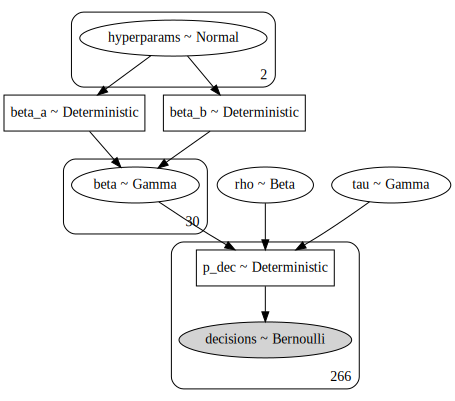

In [65]:
pm.model_to_graphviz(model)

#### Sampling

In [66]:
sample_size = 10000
tune_size = 3000

random_seed = 123
trace = sample_model(model, sample_size, tune_size, target_accept=0.8, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, tau, beta, hyperparams]
Sampling 2 chains, 2 divergences: 100%|██████████| 26000/26000 [03:16<00:00, 132.64draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [67]:
# az.plot_posterior(trace, var_names=["rho", "tau", "beta", "hyperparams"])

#### Plotting

In [68]:
def plot_nice_density(data, ax=None, hpdi_width=0.95, x_lim=None, param_name=r'$\alpha$', fontsize=14, ref_value=None, c='C0', on_unit=False):
    if ax is None:
        fig, ax = plt.subplots()

    hpdi = az.hdi(data.flatten(), hpdi_width)
    az.plot_posterior(data.T, hdi_prob='hide', point_estimate=None, ax=ax, c=c)
    
    density_line = ax.get_lines()[-1]
    pdf_x, pdf_y = density_line.get_data()
    hdi_mask = (pdf_x >= hpdi[0]) & (pdf_x <= hpdi[1])
    ax.fill_between(pdf_x[hdi_mask], pdf_y[hdi_mask], color=density_line.get_color(), alpha=0.3, label='%d%% HPDI' % int(hpdi_width * 100))
    if x_lim is not None:
        ax.set_xlim(x_lim)
    ax.set_ylim([0, ax.get_ylim()[1]])
    
    points = [data.mean(), hpdi[0], hpdi[1]]

    points_y = np.interp(points, pdf_x, pdf_y)
    ax.vlines(points[0], ymin=0, ymax=points_y[0], ls='--', color=density_line.get_color())
    for i, (point_x, point_y) in enumerate(zip(points, points_y)):
        quantity_label = '%.2f' % point_x 
        if on_unit:
            quantity_label = quantity_label.lstrip('0')
        label = (r'$%s$' % quantity_label) if i > 0 else r'$E[$%s$|y]=%s$' % (param_name, quantity_label)
        ax.annotate(label, xy=(point_x, point_y), va='top', in_layout=False, fontsize='large', backgroundcolor=(1, 1, 1, 0.0))

    if ref_value is not None:
        hdi_mask = (pdf_x >= ref_value)
        prob = (data > ref_value).mean()
        ax.fill_between(pdf_x[hdi_mask], pdf_y[hdi_mask], edgecolor=c, facecolor='none', hatch='//', alpha=0.8, label=r'$p($%s$> %d|y)=%.2f$' % (param_name, ref_value, prob))
        ax.annotate((r'$%.2f$' % prob), xy=(ref_value * 1.2, pdf_y.max()*0.1), xycoords='data', color=c, fontweight='bold', fontsize='large')

    ax.legend()
    ax.set_xlabel(param_name, fontsize='large')
    # ax.set_xlabel('')
    ax.set_ylabel(r'$p($%s$|y)$' % param_name, fontsize='large')
    ax.set_title('')
    
    return ax

In [69]:
p_codes = list(choicesDF[choicesDF.Treatment > 0].Participant.factorize()[1])

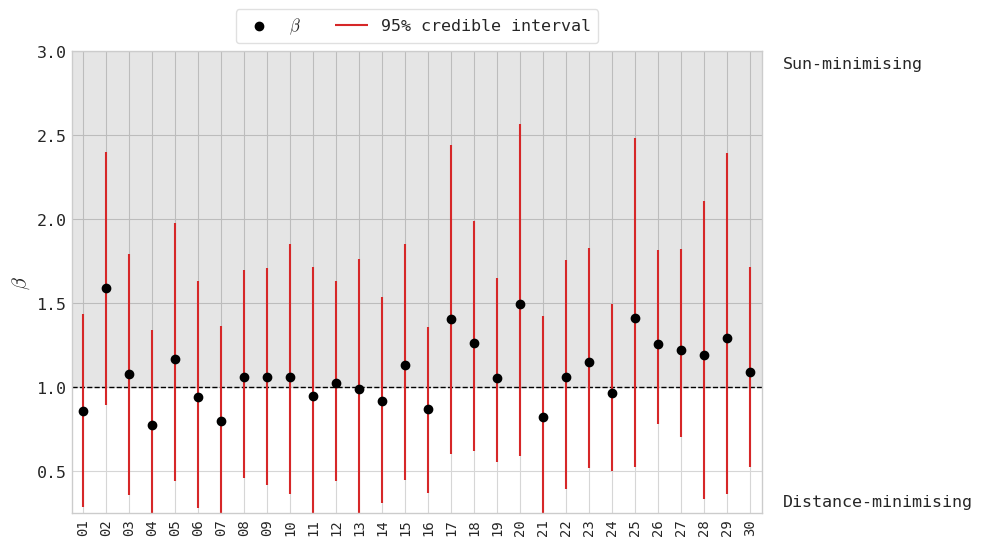

In [91]:
# Setting up the figure directly
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figsize for better layout

betas = trace.beta
ordered_p_codes = participant_codes
x = np.arange(len(participant_codes))
y = betas.mean(axis=0)

beta_hpdis = np.zeros((betas.shape[1], 2))

for i in range(beta_hpdis.shape[0]):
    beta_hpdis[i] = az.hdi(betas[:, i], 0.95)

ax.hlines([1], xmin=-0.5, xmax=len(participant_codes)+0.5, ls='--', color='black', lw=1)
ylim = [0.25, 3]
ax.axhspan(ymax=1, ymin=ylim[0], facecolor='white', alpha=0.2)
ax.axhspan(ymax=ylim[1], ymin=1, facecolor='grey', alpha=0.2)

ax.scatter(x, y, zorder=10, label=r'$\beta$', color='black')
ax.vlines(x, ymin=beta_hpdis[:, 0], ymax=beta_hpdis[:, 1], color='C3', label='95% credible interval')
ax.set_xticks(x)
x_labels = ['%02d' % (p_codes.index(p_code_i)+1) for i, p_code_i in enumerate(ordered_p_codes)]
labels = ax.set_xticklabels(x_labels, rotation=90, fontsize='small')
y_ticks = np.linspace(0.5, 3, int((3-0.5)/0.5) + 1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks)

# Adjusting the annotations to the right of the plot
ax.annotate('Distance-minimising', xy=(1.03, 0.01), xycoords='axes fraction', ha='left', va='bottom')
ax.annotate('Sun-minimising', xy=(1.03, 0.99), xycoords='axes fraction', ha='left', va='top')

ax.set_ylabel(r'$\beta$', fontsize='large')
ax.set_xlim([-.5, x.max() + 0.5])
ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1))
ax.set_ylim(ylim)

# Adjusting right margin for the annotations
fig.subplots_adjust(right=0.7)

# Assuming you have a function named savefig to save the figure
savefig(fig, 'figure4')


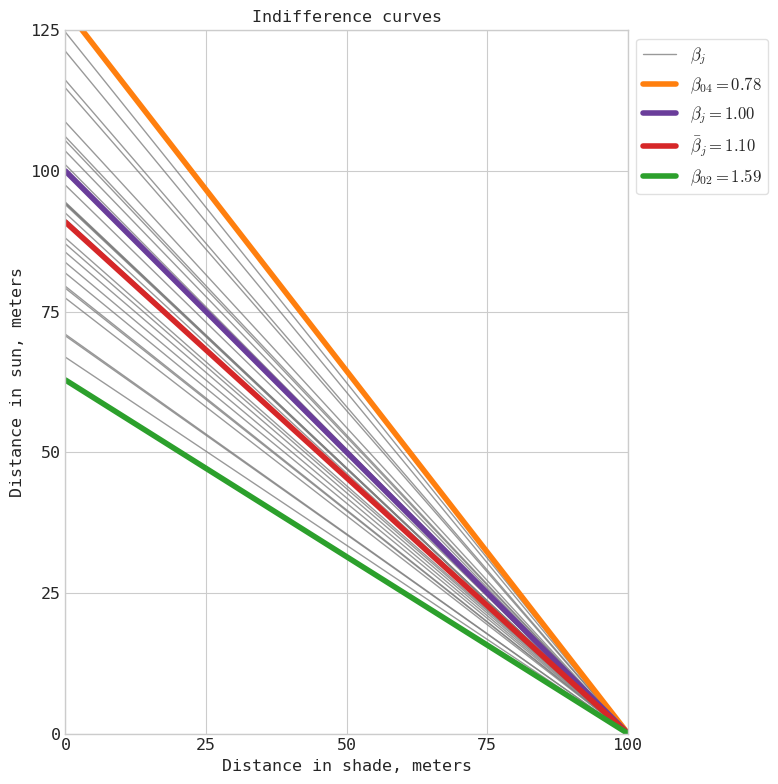

In [71]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

betas = trace.beta
ordered_p_codes = participant_codes
y = betas.mean(axis=0)

beta_hpdis = np.zeros((betas.shape[1], 2))
for i in range(beta_hpdis.shape[0]):
    beta_hpdis[i] = az.hdi(betas[:, i], 0.95)

# Indifference curves
x = 100
for i, beta_i in enumerate(y):
    label = '' if i > 0 else r'$\beta_j$'
    ax.plot([x, 0], [0, x / beta_i], c='grey', alpha=0.8, label=label, lw=1)

min_index = np.argmin(y)
max_index = np.argmax(y)

ax.plot([x, 0], [0, x / y[min_index]], c='C1', label=r'$\beta_{%02d}=%.2f$' % (min_index+1, y[min_index]), lw=4)
ax.plot([x, 0], [0, x / 1], c=np.array((106,61,154))/255, label=r'$\beta_j=%.2f$' % (1), lw=4)
ax.plot([x, 0], [0, x / y.mean()], c='C3', label=r'$\bar{\beta}_j=%.2f$' % (y.mean()), lw=4)
ax.plot([x, 0], [0, x / y[max_index]], c='C2', label=r'$\beta_{%02d}=%.2f$' % (max_index+1, y[max_index]), lw=4)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Indifference curves')

ax.set_xlim([0, 100])
ax.set_ylim([0, 125])
ax.set_xlabel(r'Distance in shade, meters')
ax.set_ylabel(r'Distance in sun, meters')

ax.set_xticks(np.arange(0, 100+1, 25))
ax.set_yticks(np.arange(0, 125+1, 25))

ax.set_aspect('equal', anchor='SW')

fig.tight_layout()

savefig(fig, 'figure5')

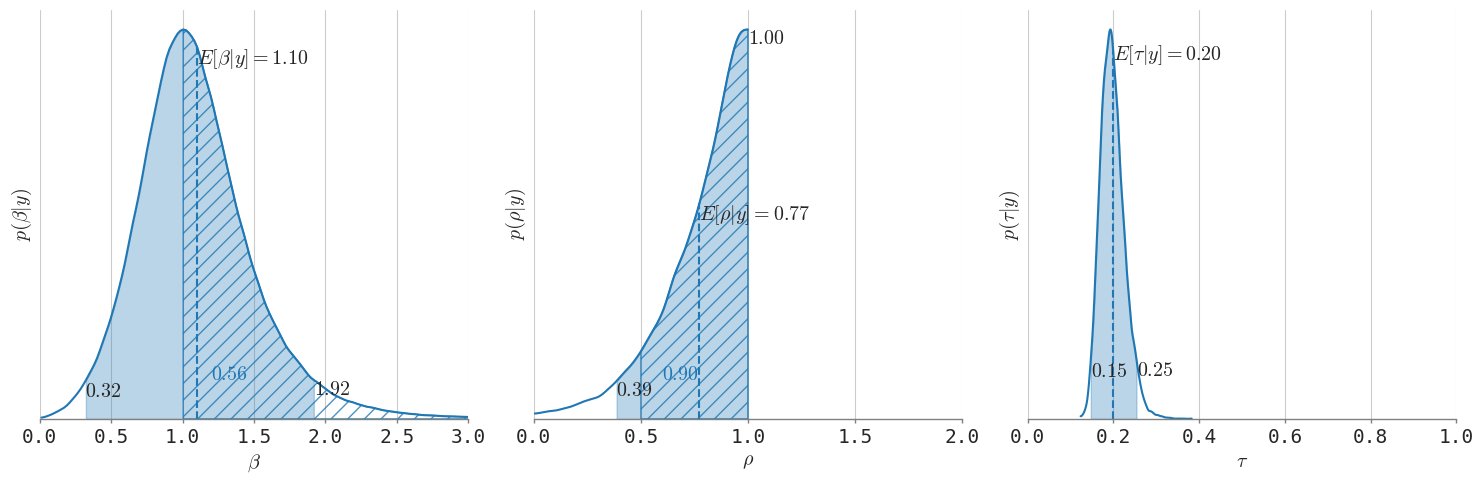

In [72]:
# Setup the figure and grid
fig = plt.figure(figsize=(15, 5))  # Adjust the figure size if needed
gs = GridSpec(1, 3, figure=fig)

# Plot Common beta
ax = fig.add_subplot(gs[0, 0])
plot_nice_density(trace.beta, ax=ax, x_lim=[0, 3], param_name=r'$\beta$', ref_value=1, c='C0')
ax.get_legend().remove()

# Plot Rho
ax = fig.add_subplot(gs[0, 1])
plot_nice_density(trace.rho, ax=ax, x_lim=[0, 2], param_name=r'$\rho$', ref_value=0.5, c='C0', on_unit=False)
ax.get_legend().remove()

# Plot Common tau
ax = fig.add_subplot(gs[0, 2])
plot_nice_density(trace.tau, ax=ax, x_lim=[0, 1], param_name=r'$\tau$', ref_value=1, c='C0')
ax.get_legend().remove()

# Adjust layout
fig.tight_layout()
plt.show()